***
** Algorithmes d'optimisation -- L3 MINT et doubles licences 2017/2018 -- Université Paris-Sud **
***

$\newcommand{\Rsp}{\mathbb{R}}
\newcommand{\nr}[1]{\|#1\|}
\newcommand{\abs}[1]{|#1|}
\newcommand{\eps}{\varepsilon}
\newcommand{\sca}[2]{\langle#1|#2\rangle}
\newcommand{\D}{\mathrm{D}}
\newcommand{\hdots}{\dots}
\newcommand{\cond}{\mathrm{cond}}$

# TP 3: Régression logistique

## Partie I: Comparaison de la descente de gradient et de Newton en dimension $d=2$

L'explication de la méthode est à lire dans la feuille de TD.
On commence par construire les données $(x_i)_{i\in I \cup J} \subseteq \Rsp^2$: 
- Les points $(x_i)_{i\in I}$ sont tirés selon une gaussienne centrée en $(0.5,0.5)$
- Les points $(x_j)_{j\in J}$ sont tirés selon une gaussienne centrée en $(-0.5,-0.5)$.

On cherche alors à construire, par optimisation de la fonction $F$, un vecteur $w\in\Rsp^2$ tel
que $\sigma(\sca{w}{x_i}) \simeq 0$ si $i\in I$ et  $\sigma(\sca{w}{x_i})\simeq 1$ si $i\in J$.

On définit également des fonctions tirées des TP précédents:
- backtrack(f,x,d,m) calcule le pas d'Armijo, où $m=\sca{d}{\nabla f(x)}$.
- gradient_backtracking(f,g,x0): calcule le minimum de $f$ par méthode du gradient avec backtracking d'Armijo
- check_gradient(f,g,x0): vérifie (numériquement) que la fonction $g$ correspond  bien au gradient de $f$ en $x_0$
- check_hessian(g,h,x0): vérifie (numériquement) que la fonction $h$ correspond  bien à la dérivée de $g$ en $x_0$

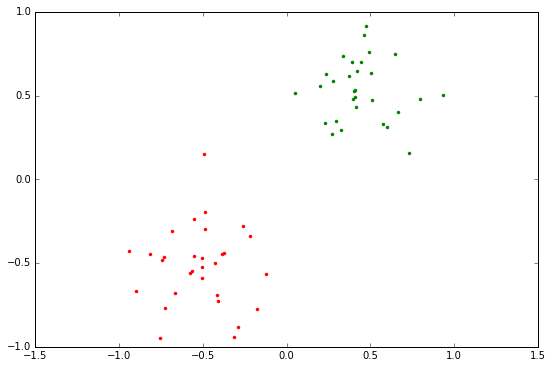

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# la commande suivante agrandit les figures
plt.rcParams['figure.figsize'] = [9.,6.]

# initialiser les variables K,Q, x0, fmin
n = 30
X = np.vstack((np.hstack((-0.5+.2*np.random.randn(n,1), -0.5 + .2*np.random.randn(n,1))),
               np.hstack((0.5+.2*np.random.randn(n,1), 0.5 + .2*np.random.randn(n,1)))))
I = range(0,n)
J = range(n,2*n)
plt.plot(X[I,0],X[I,1],'.r')
plt.plot(X[J,0],X[J,1],'.g')
plt.axis('equal');



In [3]:
# on recupere ici des fonctions issues des TP précédents. Seule la fonction check_hessian est nouvelle.

def backtrack(f,x,d,m,alpha=0.3,beta=0.5):
    t = 1
    while f(x+t*d) > f(x) + alpha*t*m:
        t = beta*t
    return t

def gradient_backtracking(f,g,x0,err=1e-6,maxiter=500):
    x = x0.copy()
    fiter = []
    giter = []
    k = 0 # nombre d'itérations
    while(True): 
        k = k+1
        if k > maxiter: # maximum de 10^6 itérations
            print('erreur: nombre maximum d\'itérations atteint')
            break
        d = -g(x)
        fiter.append(f(x))
        giter.append(np.linalg.norm(d))
        if np.linalg.norm(d) <= err:
            break
        t = backtrack(f,x,d,-np.linalg.norm(d)**2)
        if k%10==0: # on affiche des informations toute les 20 itérations
            print('iteration %d: f=%f, |g|=%f, step=%f' % (k, f(x), np.linalg.norm(d),t))
        x = x + t*d
    return x,np.array(fiter),np.array(giter)

def check_gradient(f,g,x0):
    N = len(x0)
    gg = np.zeros(N)
    for i in range(N):
        eps = 1e-4
        e = np.zeros(N)
        e[i] = eps
        gg[i] = (f(x0+e) - f(x0-e))/(2*eps)
    print('erreur numerique dans le calcul du gradient: %g (doit etre petit)' % np.linalg.norm(g(x0)-gg))

# cette fonction vérifie que h (=fonction évaluant le hessian) est bien la dérivée
# de g (= fonction évaluant le gradient), en un point x0
def check_hessian(g,h,x0):
    N = len(x0)
    H = np.zeros((N,N))
    for i in range(N):
        eps = 1e-5
        e = np.zeros(N)
        e[i] = eps
        H[i,:] = (g(x0+e) - g(x0-e))/(2*eps)
    print('erreur numerique dans le calcul de la hessienne: %g (doit etre petit)' % np.sum((H-h(x0)))**2)

**QI.1**: Écrire une fonction $F(w,X,I,J,\gamma)$ et $gF(w,X,I,J,\gamma)$ calculant la valeur et le gradient de la fonctionnelle 

$$ F(w) = - \left(\sum_{i\in I} \log(1-\sigma(\sca{w}{x_i})) + \sum_{i\in J} \log(\sigma(\sca{w}{x_i})\right) + \frac{\gamma}{2} \nr{w}^2. $$

Tester que $gF$ correspond bien au gradient de $F$ en utilisant la fonction check_gradient.

In [4]:
# on définit une fonction sigma(t) correspondant à la sigmoïde
def sigma(t):
    return 1/(1+np.exp(-t))

def F(w,X,I,J,gamma):
    # on calcule F en utilisant la formule (on pourra utiliser np.sum)
    h = sigma(np.dot(X,w.T))
    return -(np.sum(np.log(1.-h[I])) + np.sum(np.log(h[J]))) + .5*gamma*np.dot(w,w)

def gF(w,X,I,J,gamma):
    d = len(w)
    g = np.zeros(d)
    # on calcule le gradient en appliquant la formule obtenue en TD
    h = sigma(np.dot(X,w.T))
    for i in I: g += h[i]*X[i,:]
    for j in J: g += (h[j]-1)*X[j,:]
    g += gamma*w
    return g

# on vérifie le calcul du gradient en utilisant la fonction check_gradient
# rappel: on peut utiliser f = lambda w: F(w,X,I,J,gamma) pour définir 
# f(w) = F(w,X,I,J,gamma)
gamma = .1
check_gradient(lambda w: F(w,X,I,J,gamma),
               lambda w: gF(w,X,I,J,gamma), np.random.rand(2))


erreur numerique dans le calcul du gradient: 2.4316e-09 (doit etre petit)


**QI.2**: Calculer $w=\arg\min_{\Rsp^2} F$ en utilisant la fonction gradient_backtracking. Tracer sur un graphe l'évolution de la norme du gradient au cours des itérations de la descente de gradient, soit $(k,\nr{\nabla F(w^{(k)})})$, où l'axe $y$ sera en échelle logarithmique.

iteration 10: f=0.869162, |g|=0.138801, step=1.000000
iteration 20: f=0.783502, |g|=0.054698, step=1.000000
iteration 30: f=0.766904, |g|=0.027903, step=1.000000
iteration 40: f=0.762141, |g|=0.016022, step=1.000000
iteration 50: f=0.760460, |g|=0.009998, step=1.000000
iteration 60: f=0.759767, |g|=0.006669, step=1.000000
iteration 70: f=0.759445, |g|=0.004682, step=1.000000
iteration 80: f=0.759281, |g|=0.003406, step=1.000000
iteration 90: f=0.759192, |g|=0.002534, step=1.000000
iteration 100: f=0.759143, |g|=0.001910, step=1.000000
iteration 110: f=0.759114, |g|=0.001450, step=1.000000
iteration 120: f=0.759098, |g|=0.001106, step=1.000000
iteration 130: f=0.759088, |g|=0.000846, step=1.000000
iteration 140: f=0.759082, |g|=0.000648, step=1.000000
iteration 150: f=0.759079, |g|=0.000496, step=1.000000
iteration 160: f=0.759077, |g|=0.000380, step=1.000000
iteration 170: f=0.759076, |g|=0.000292, step=1.000000
iteration 180: f=0.759075, |g|=0.000224, step=1.000000
iteration 190: f=0.

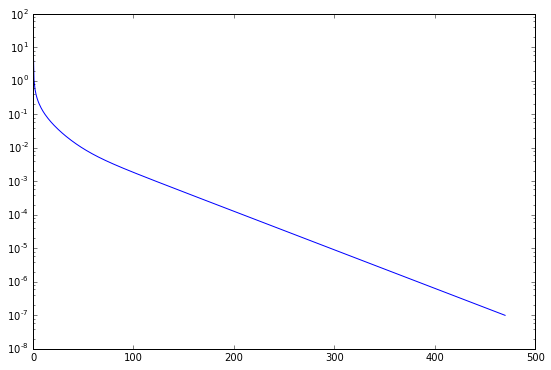

In [5]:
w0 = np.zeros(2) 
gamma = .01
w,fiter,giter = gradient_backtracking(lambda w: F(w,X,I,J,gamma),
                                         lambda w: gF(w,X,I,J,gamma), w0, err=1e-7, maxiter=1000)
plt.semilogy(giter)


**QI.3**: Soit $w$ le minimiseur approché de $F$ calculé dans la question précédente. Tracer sur un graphe:
- les points $(x_i)_{i\in I}$ en rouge
- les points $(x_j)_{j\in J}$ en bleu
- quelques lignes de niveau de la fonction $u:x\mapsto \sigma(\sca{w}{x_i})$ en utilisant la fonction plt.contour().

Faire varier le paramètre de régularisation $\gamma \in \{0.01,0.1,1,10\}$ et observer:
- comment varie le nombre d'itérations.
- comment varie $\nr{w}$ (où $\nr{w}$ est le minimiseur).
- quel est l'effet sur la fonction $u:x\mapsto \sigma(\sca{w}{x_i})$.

<!--
%On peut expliquer le premier point en se rappelant que
%Si on note $F_\gamma$ la fonction avec le paramètre $\gamma$, montrer que pour $\gamma' \geq \gamma$ on a 
%$$ \forall w\in\Rsp^d,\forall v\in \Rsp^d, \sca{D^2 F_\gamma(w)v}{v} \leq \sca{D^2 F_{\gamma'}(w)v}{v} $$
%En déduire que si $m \leq \D^2 F_\gamma \leq M$ sur $S\subseteq \Rsp^d$, alors 
%$$ m+(\gamma'-\gamma) \leq \D^2 F_\gamma \leq M + \gamma'-\gamma $$
%, en notant $\lambda_1(A) < \hdots \leq \lambda_d(A)$ les valeurs propres de $A$,
%$$ \frac{\lambda_d(A')}{\lambda_1(A')} \leq \frac{\lambda_d(A)}{\lambda_1(A)} $$
$$
-->

iteration 10: f=0.869162, |g|=0.138801, step=1.000000
iteration 20: f=0.783502, |g|=0.054698, step=1.000000
iteration 30: f=0.766904, |g|=0.027903, step=1.000000
iteration 40: f=0.762141, |g|=0.016022, step=1.000000
iteration 50: f=0.760460, |g|=0.009998, step=1.000000
iteration 60: f=0.759767, |g|=0.006669, step=1.000000
iteration 70: f=0.759445, |g|=0.004682, step=1.000000
iteration 80: f=0.759281, |g|=0.003406, step=1.000000
iteration 90: f=0.759192, |g|=0.002534, step=1.000000
iteration 100: f=0.759143, |g|=0.001910, step=1.000000
iteration 110: f=0.759114, |g|=0.001450, step=1.000000
iteration 120: f=0.759098, |g|=0.001106, step=1.000000
iteration 130: f=0.759088, |g|=0.000846, step=1.000000
iteration 140: f=0.759082, |g|=0.000648, step=1.000000
iteration 150: f=0.759079, |g|=0.000496, step=1.000000
iteration 160: f=0.759077, |g|=0.000380, step=1.000000
iteration 170: f=0.759076, |g|=0.000292, step=1.000000
iteration 180: f=0.759075, |g|=0.000224, step=1.000000
iteration 190: f=0.

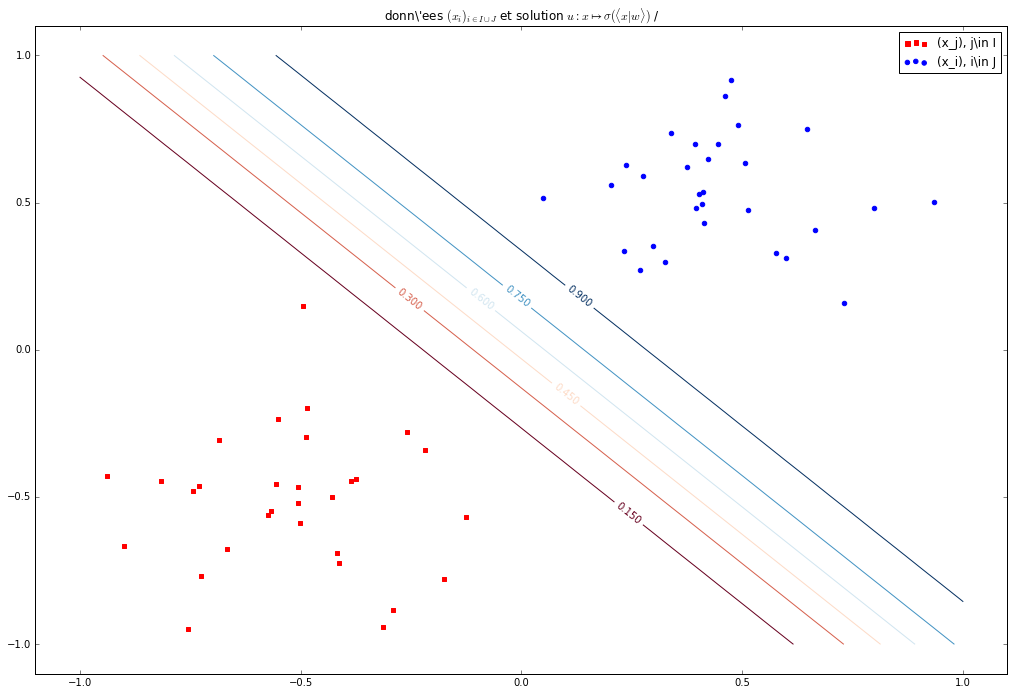

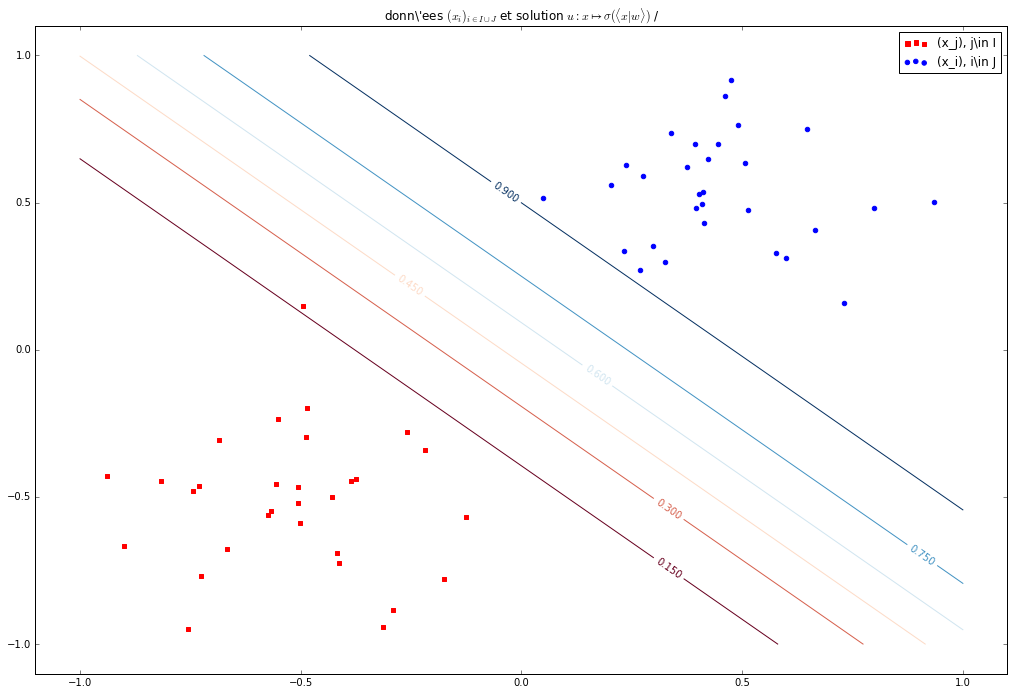

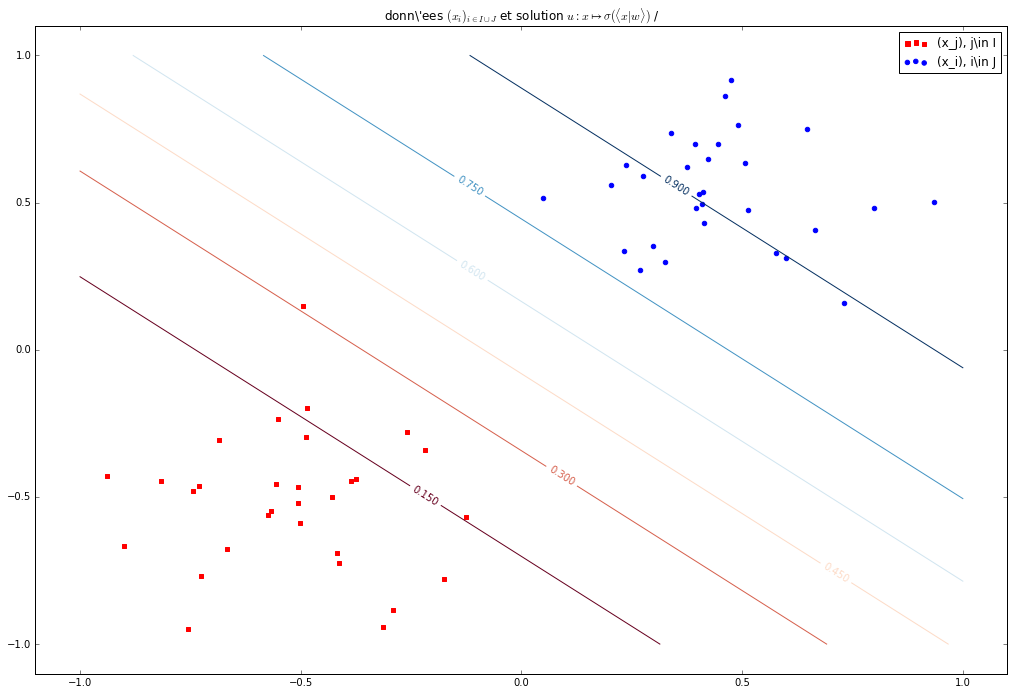

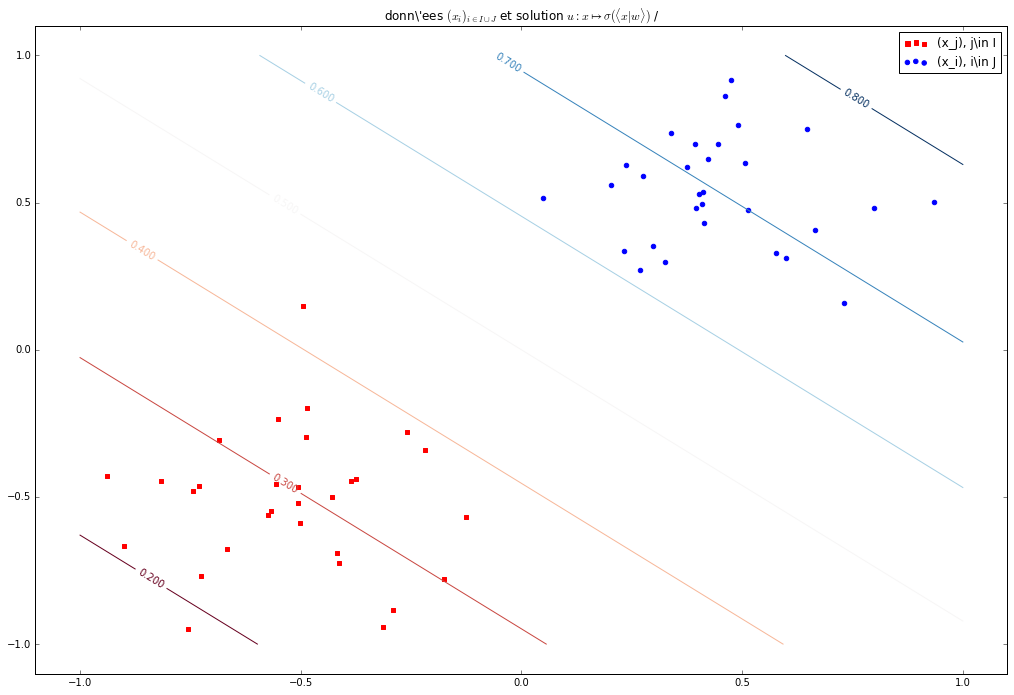

In [6]:
# on définit une fonction permettant d'afficher les lignes de niveaux de u: R^2 -> R
# NB: u peut être définie en utilisant lambda, par exemple:
#    u = lambda (x,y): ... où x,y sont les coordonnées du point
def lignes_niveau(u):
    Xcontour,Ycontour = np.meshgrid(np.linspace(-1., 1., 100),
                                    np.linspace(-1., 1., 100))
    Zcontour = u(Xcontour,Ycontour)
    plt.axes([-1.5, -1.5, 1.5, 1.5])
    plt.axis('equal')
    p = plt.contour(Xcontour, Ycontour, Zcontour, cmap='RdBu')
    plt.clabel(p, inline=1, fontsize=10)
    
for gamma in [0.01,0.1,1,10]:
    w,fiter,giter = gradient_backtracking(lambda w: F(w,X,I,J,gamma),
                                          lambda w: gF(w,X,I,J,gamma), 
                                          np.zeros(2), err=1e-7, maxiter=1000)
    print('gamma = %d: niter = %d, |w|=%g' % (gamma,len(fiter),np.linalg.norm(w)))
    Xcontour,Ycontour = np.meshgrid(np.linspace(-1., 1., 100),
                                    np.linspace(-1., 1., 100))
    
    plt.figure()
    lignes_niveau(lambda x,y: sigma(x*w[0] + y*w[1]))
    plt.scatter(X[I,0],X[I,1],marker='s',color='r', label='(x_j), j\in I')
    plt.scatter(X[J,0],X[J,1],marker='o',color='b', label='(x_i), i\in J')
    plt.axis('tight')
    plt.title('donn\\\'ees $(x_i)_{i\in I\cup J}$ et solution $u: x \\mapsto \sigma(\\langle x | w\\rangle)$ / ')
    plt.legend()



**QI.4**: Écrire une fonction $hF$ calculant la hessienne de $F$, en utilisant la formule du TD. Vérifier son bon fonctionnement via check_hessian (voir l'introduction du TP).

In [7]:
def hF(w,X,I,J,K):
    h = sigma(np.dot(X,w.T))
    d = len(w)
    N = X.shape[0]
    A = K*np.eye(d)
    for i in range(N):
        A += h[i] * (1-h[i]) * np.tensordot(X[i,:],X[i,:],axes=0) 
        
    return A
check_hessian(lambda w: gF(w,X,I,J,gamma),
              lambda w: hF(w,X,I,J,gamma), np.random.rand(2))


erreur numerique dans le calcul de la hessienne: 8.3674e-21 (doit etre petit)


**Q1.5**: Écrire une fonction newton_backtracking implémentant la méthode de Newton avec backtracking (ne pas hésiter à copier-coller la fonction gradient_backtracking et à changer ce qui est nécessaire) :

$$
\begin{cases}
g^{(k)} = \nabla F(x^{(k)}) \\
d^{(k)} = -D^2 F(x^{(k)})^{-1} \nabla F(x^{(k)}) \\
m = \sca{d^{(k)}}{g^{(k)}} \\
t^{(k)} = \hbox{obtenu par backtracking d'Armijo, cf la fonction backtrack}\\
x^{(k+1)} = x^{(k)} + t^{(k)} d^{(k)}
\end{cases}
$$

Utiliser cette fonction pour calculer le minimum de $F$. Comme dans la question Q1.2, tracer la norme du gradient en fonction de l'itération. Vérifier également que le nombre d'itérations dépend peu du choix du paramètre $\gamma$.

iteration 1: f=41.588831, |g|=21.362260, step=1.000000
iteration 2: f=9.690587, |g|=5.491137, step=1.000000
iteration 3: f=3.890789, |g|=2.001470, step=1.000000
iteration 4: f=1.779552, |g|=0.737436, step=1.000000
iteration 5: f=1.015670, |g|=0.257076, step=1.000000
iteration 6: f=0.794580, |g|=0.073995, step=1.000000
iteration 7: f=0.760364, |g|=0.012390, step=1.000000
iteration 8: f=0.759077, |g|=0.000524, step=1.000000
iteration 9: f=0.759074, |g|=0.000001, step=1.000000
iteration 1: f=41.588831, |g|=21.362260, step=1.000000
iteration 2: f=10.147224, |g|=5.352513, step=1.000000
iteration 3: f=4.959125, |g|=1.802366, step=1.000000
iteration 4: f=3.565504, |g|=0.515521, step=1.000000
iteration 5: f=3.352376, |g|=0.085191, step=1.000000
iteration 6: f=3.344638, |g|=0.003410, step=1.000000
iteration 7: f=3.344625, |g|=0.000006, step=1.000000
iteration 1: f=41.588831, |g|=21.362260, step=1.000000
iteration 2: f=14.047299, |g|=4.186157, step=1.000000
iteration 3: f=12.023820, |g|=0.696488

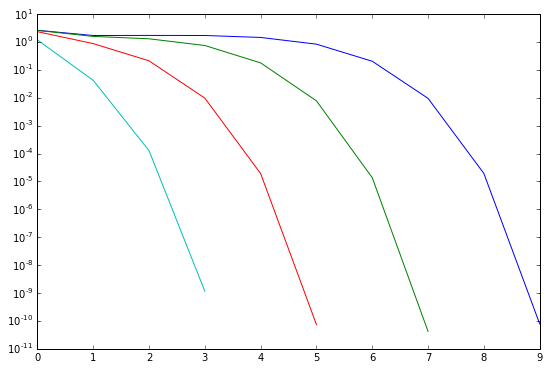

In [8]:
def newton_backtracking(f,g,h,x0,err=1e-6,maxiter=500):
    # la boucle est tres similaire à celle de gradient_backtracking: la seule chose qui
    # change est le choix de la direction de descente. 
    # NB: on utilise np.linalg.solve pour résoudre le système linéaire apparaissant dans la méthode
    x = x0.copy()
    fIter = []
    gIter = []
    k = 0
    while(True):
        k = k+1
        if k > maxiter: # maximum de 10^6 itérations
            print('erreur: nombre maximum d\'itérations atteint')
            break
        gx = -g(x)
        dx = np.linalg.solve(h(x),gx)
        fIter.append(f(x))
        gIter.append(np.linalg.norm(dx))
        if np.abs(np.linalg.norm(gx)) <= err:
            break
        t = backtrack(f,x,dx,np.dot(gx,dx))
        print('iteration %d: f=%f, |g|=%f, step=%f' % (k, f(x), np.linalg.norm(gx),t))
        x = x + t*dx
    return x,np.array(fIter),np.array(gIter)


# comparer le nombre d'iterations dans la methode de Newton pour gamma dans [0.01,0.1,1,10]
for gamma in [0.01,0.1,1,10]:
    w0 = np.zeros(2)
    w,fiter,giter = newton_backtracking(lambda w: F(w,X,I,J,gamma),
                                        lambda w: gF(w,X,I,J,gamma),
                                        lambda w: hF(w,X,I,J,gamma), w0, 1e-7, 1000)
    plt.semilogy(giter)


## II Application à la reconnaissance d'écriture manuscrite

On applique la méthode décrite dans la partie I (où l'on traitait des données en dimension $d=2$) à un jeu de données de dimension beaucoup plus grande. L'objectif est de distinguer des caractères manuscrits: pour cela, on a demandé à 6000 personnes d'écrire les chiffres de $0$ à $9$. Ici, l'on cherchera à distinguer les $0$ des $1$. Chaque point $x_i \in \Rsp^{784}$ est construit de la manière suivante: 

- On demande à une personne d'écrire le chiffre $0$, que l'on stocke sous la forme d'une image en niveaux de gris de taille 28x28 pixels, que l'on représente par une matrice carrée $p_i = ((p_i)_{mn})_{1\leq n\leq m\leq 28}$ où $p_{mn}\in[0,1]$ ($(p_i)_{nm} = 0$ si le pixel $(m,n)$ est noir et $1$ s'il est blanc). 
- Cette matrice carrée est convertie en un vecteur $x$ de taille $d = 28\times 28 = 784$. Pour cela, on concatène simplement les lignes de $p$:
$$ \forall 1\leq n,m \leq 28,\qquad (x_{i})_{n + (m-1) d} = (p_i)_{nm} $$
- Enfin, on enregistre à part l'entier correspondant au chiffre manuscrit (on appelle ça le "label", ou étiquette, de l'image).

La fonction read_mnist() ci-dessous télécharge ces données et retourne deux tableaux numpy *images* et *labels*:
- le premier tableau contient la liste des images, sous la forme d'un tableau ayant n lignes ($n$ est le nombre de chiffres manuscrit, ici $60000$, soit $6000$ tracé de chaque chiffre 0,1,2...,9) et $784=28^2$ colonnes. Chaque ligne $i$ représente une image, que l'on peut afficher avec la fonction show_mnist(images[i])
- le deuxième tableau est un vecteur à $n$ entrée: labels[i] est l'entier correspondant au chiffre manuscrit stocké dans images[i]

In [9]:
# MNIST
import os
import struct
import urllib
import gzip
import shutil
try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve

def gunzip(iname,oname):
    with gzip.open(iname, 'rb') as f_in:
        with open(oname, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
def download_mnist(dest):
    src = 'http://yann.lecun.com/exdb/mnist'
    for f in ['train-images-idx3-ubyte', 'train-labels-idx1-ubyte']:
        urlretrieve('%s/%s.gz' % (src,f), '%s/%s.gz' % (dest,f))
        gunzip('%s/%s.gz' % (dest,f),'%s/%s' % (dest,f))
def read_mnist():
    d = os.path.expanduser('~/.m315-mnist-data')
    if not os.path.isdir(d):
        os.makedirs(d)
        download_mnist(d)
    with open('%s/train-labels-idx1-ubyte' % d, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        labels = np.fromfile(flbl, dtype=np.int8)
    with open('%s/train-images-idx3-ubyte' % d, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        images = np.fromfile(fimg, dtype=np.uint8).reshape(len(labels), rows*cols)/255.
    return images,labels
def show_mnist(image, cmap='gray'):
    plt.figure()
    imgplot = plt.imshow(np.reshape(image,(28,28)), interpolation='nearest', cmap=cmap)
   
images,labels = read_mnist()

Il faut passer quelques minutes à jouer avec les fonctions show_mnist() et print() (afficher les labels, et aussi les vecteurs images[i]) pour comprendre le jeu de données.

7


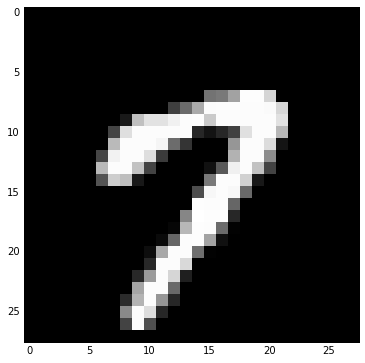

In [10]:
# exemple d'image: faire varier un peu i pour comprendre le jeu de données
i = 15
show_mnist(images[i])
print(labels[i])

**QII.1** Construire un tableau $X0$ contenant $n=100$ images du chiffre $0$ extraite du tableau 'images', et un tableau $X1$ contenant également $n$ représentants du chiffre $1$ également extraits de images (X0 et X1 possèderont donc $n$ lignes et $784$ colonnes). Construire ensuite les données du problème d'optimisation:
- Un tableau X de $2\times n$ lignes et $784$ colonnes obtenu en mettant à bout $X0$ et $X1$ (on pourra utiliser np.vstack). 
- Un tableau I (resp. J) contenant la liste des indices correspondant aux 0 (resp 1).

In [11]:
ntot = len(labels)
n = 100 # nombre d'images par classe
X0 = [images[i] for i in range(ntot) if labels[i] == 0][0:n]
X1 = [images[i] for i in range(ntot) if labels[i] == 1][0:n]
X = np.vstack((X0,X1))
I = range(0,n)
J = range(n,2*n)


**QII.2** Résoudre le problème d'optimisation $\min_{w\in\Rsp^d} F(w)$ pour $\gamma=0.1$ en utilisant la méthode de Newton.

In [12]:
gamma = .1
w0 = np.zeros(784)
w,fIter,gIter = newton_backtracking(lambda w: F(w,X,I,J,gamma),
                                    lambda w: gF(w,X,I,J,gamma),
                                    lambda w: hF(w,X,I,J,gamma),w0, 
                                    err=1e-8,maxiter=5000)


iteration 1: f=138.629436, |g|=377.194291, step=1.000000
iteration 2: f=25.816351, |g|=89.958706, step=1.000000
iteration 3: f=9.159966, |g|=31.569106, step=1.000000
iteration 4: f=3.712922, |g|=11.593728, step=1.000000
iteration 5: f=1.701434, |g|=4.355502, step=1.000000
iteration 6: f=0.926405, |g|=1.640519, step=1.000000
iteration 7: f=0.640555, |g|=0.598944, step=1.000000
iteration 8: f=0.557049, |g|=0.190618, step=1.000000
iteration 9: f=0.543141, |g|=0.041410, step=1.000000
iteration 10: f=0.542359, |g|=0.003433, step=1.000000
iteration 11: f=0.542354, |g|=0.000029, step=1.000000


Soit $w$ la solution du problème d'optimisation et $u:x\mapsto\sigma(\sca{x}{w})$. L'idée de la régression logistique (cf intro du TD) est que  $u(x) \simeq 1$ si $x$ représente un $1$ et $u(x) \simeq 0$ si $x$ représente un $0$. On n'a utilisé qu'une petite fraction des images pour construire $w$ (on a choisi $n=100$ images de $0$ alors que la base de données en contient $6000$): l'idée est de valider la méthode en comparant la classe ($0$ où $1$) devinée par la fonction $u$ à celle enregistrée dans le tableau labels sur l'ensemble des $0$ et $1$ de la base de données.

**QII.3** Vérifier la pertinence de la méthode de la manière suivante :
- Pour chaque image MNIST $x = images[i]$ représentant un $0$ où un $1$ (pour tout $i$ tel que labels[i] $\in \{0,1\}$), calculer $u(x)$, et définir label_devine=0 si $u(x)\leq 1/2$ et $1$ sinon.
- Comparer  label_devine au véritables label (labels[i]).
- Calculer enfin la proportion de cas où label_devine=labels[i]: cela mesure l'efficacité de la régression logistique.

In [13]:
total = 0
correct = 0
for i in range(ntot):
    if labels[i] not in [0,1]:
        continue
    P = sigma(np.dot(images[i],w.T)) > .5
    total = total+1
    if P==labels[i]:
        correct = correct+1
print('pourcentage de cas ou le chiffre 0 est correctement reconnu: %g%%' % (100.*float(correct)/float(total)))

pourcentage de cas ou le chiffre 0 est correctement reconnu: 99.6447%


**QII.4:** Afficher le vecteur $w$ sous la forme d'une image en utilisant show_mnist(). Interpréter.

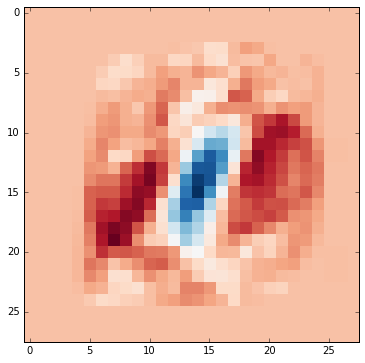

In [14]:
show_mnist(np.reshape(w,(28,28)),cmap='RdBu')


**QII.5** Adapter l'approche à la séparation des chiffres 0 de tout les autres chiffres. (on pourra prendre n=100 chiffres $0$ et $n$ chiffres de chaque autre classe, soit 1000 points de donnée au total).

iteration 1: f=693.147181, |g|=2277.565327, step=1.000000
iteration 2: f=186.520113, |g|=572.343704, step=1.000000
iteration 3: f=98.207586, |g|=205.937616, step=1.000000
iteration 4: f=69.212164, |g|=71.872824, step=1.000000
iteration 5: f=61.692959, |g|=20.282336, step=1.000000
iteration 6: f=60.731338, |g|=3.026784, step=1.000000
iteration 7: f=60.706153, |g|=0.092316, step=1.000000
iteration 8: f=60.706130, |g|=0.000092, step=1.000000
pourcentage de cas ou le chiffre 0 est correctement reconnu: 98.6%


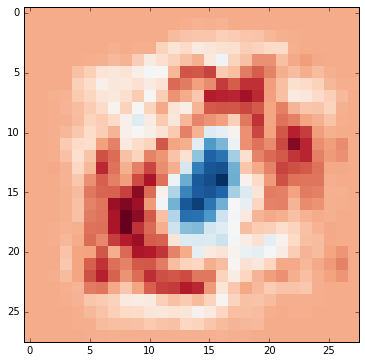

In [15]:
n = 100 # nombre d'images par classe
X0 = [images[i] for i in range(ntot) if labels[i] == 0][0:n]
X1 = [images[i] for i in range(ntot) if labels[i] >= 1][0:9*n]
X = np.vstack((X0,X1))
I = range(0,n)
J = range(n,10*n)

gamma = 10
w0 = np.zeros(784)
w,fIter,gIter = newton_backtracking(lambda w: F(w,X,I,J,gamma),
                                    lambda w: gF(w,X,I,J,gamma),
                                    lambda w: hF(w,X,I,J,gamma),w0, 
                                    err=1e-8,maxiter=5000)
show_mnist(np.reshape(w,(28,28)),cmap='RdBu')

total = 0
correct = 0
for i in range(ntot):
    R = labels[i] >= 1
    P = sigma(np.dot(images[i],w.T)) > .5
    total = total+1
    if P==R:
        correct = correct+1
print('pourcentage de cas ou le chiffre 0 est correctement reconnu: %g%%' % (100.*float(correct)/float(total)))
